40 points task. 2 hour task

You have only one pass attempt

* Load CIFAR10. And keep only 1000 samples per each class from train (for speedup). Drop test data. All experiments you have to perform on train data (using cross-validation) and report only validation accuracy
    * from keras.datasets import cifar10
    * (x_train, y_train), (x_test, y_test) = cifar10.load_data()
* Train Random Forest on original data with light hyperparameters search
* Train CNN on original data
* Train Random Forest on latent vector (output of fully-connected layer) of trained CNN. With light hyperparameters search
* Compare results of trained models

TIPS:
If you have any errors with tf or keras try: tensorflow==1.8.0, keras==2.2.0


In [0]:
from __future__ import print_function
from keras.datasets import cifar10
import keras
from keras.layers.core import Dense, Dropout
from keras.layers import Conv2D, MaxPool2D, Flatten, UpSampling2D, MaxPooling2D
from keras.layers import Input
from keras.utils import np_utils
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from keras.regularizers import l2,l1
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score



os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [0]:
def display_images(x_data, training_data=False):
    plt.figure(figsize=(10,10))
    for i in range(0,25):
        plt.subplot(5,5, i+1)
        plt.imshow(x_data[i] )
        plt.axis('off')
        plt.xticks([])
        plt.yticks([])

## Load Data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170500096/170498071 [==============================] - 6s 0us/step


In [0]:
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)

In [4]:
x_train.shape

(50000, 32, 32, 3)

In [0]:
X = []
Y = []
for label in np.unique(y_train):
    count = 0 
    for i in range(len(x_train)):
        if y_train[i] == label:
            X.append(x_train[i].reshape(32,32,3))
            Y.append(y_train[i])
            count += 1
        if count == 1000:
            break

X = np.array(X)
Y = np.array(Y)
Y = Y.reshape(10000)

In [6]:
print(X.shape, Y.shape)

(10000, 32, 32, 3) (10000,)


In [0]:
X = np.array([X[i]/np.float(255) for i in range(len(X)) ])
num_class = 10

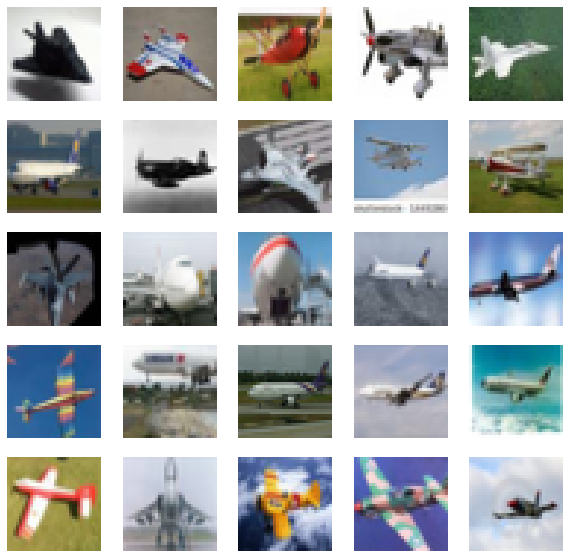

In [14]:
display_images(X)

In [0]:
parameters_rf = {
    'max_depth' : [5,10,15],
    'n_estimators' : [16, 32]
}

In [0]:
rf1 = RandomForestClassifier()

In [0]:
X_rf = X.reshape(10000, 32*32*3)

In [12]:
CV_rfc = GridSearchCV(estimator=rf1, param_grid=parameters_rf, cv=3, verbose=2)
CV_rfc.fit(X_rf, Y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] max_depth=5, n_estimators=16 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... max_depth=5, n_estimators=16, total=   1.9s
[CV] max_depth=5, n_estimators=16 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ..................... max_depth=5, n_estimators=16, total=   1.8s
[CV] max_depth=5, n_estimators=16 ....................................
[CV] ..................... max_depth=5, n_estimators=16, total=   1.7s
[CV] max_depth=5, n_estimators=32 ....................................
[CV] ..................... max_depth=5, n_estimators=32, total=   3.3s
[CV] max_depth=5, n_estimators=32 ....................................
[CV] ..................... max_depth=5, n_estimators=32, total=   3.3s
[CV] max_depth=5, n_estimators=32 ....................................
[CV] ..................... max_depth=5, n_estimators=32, total=   3.3s
[CV] max_depth=10, n_estimators=16 ...................................
[CV] .................... max_depth=10, n_estimators=16, total=   3.2s
[CV] max_depth=10, n_estimators=16 ...................................
[CV] .................... max_depth=10, n_estimators=16, total=   3.3s
[CV] max_depth=10, n_estimators=16 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [15]:
final_model_rf1 = CV_rfc.best_estimator_
final_parameters_rf1 = CV_rfc.best_params_
final_rf1 = CV_rfc.best_score_

print(final_rf1)

0.3817


In [26]:
Y_oneh = keras.utils.to_categorical(Y, num_class)


kfold = StratifiedKFold(n_splits=3, shuffle=True)
cv_f1_score = []
for train, test in kfold.split(X, Y):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_class, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


    model.fit(X[train], Y_oneh[train], batch_size=128, epochs=10)
    y_predict = model.predict(X[test])
    print(y_predict[:5])
    cv_f1_score.append(accuracy_score(Y_oneh[test], y_predict))
    


Epoch 1/10
6660/6660 [==============================] - 1s 160us/step - loss: 2.0058 - acc: 0.2677
Epoch 2/10
6660/6660 [==============================] - 0s 67us/step - loss: 1.6827 - acc: 0.3985
Epoch 3/10
6660/6660 [==============================] - 0s 65us/step - loss: 1.5112 - acc: 0.4631
Epoch 4/10
6660/6660 [==============================] - 0s 64us/step - loss: 1.3974 - acc: 0.4943
Epoch 5/10
6660/6660 [==============================] - 0s 63us/step - loss: 1.3010 - acc: 0.5446
Epoch 6/10
6660/6660 [==============================] - 0s 62us/step - loss: 1.2503 - acc: 0.5580
Epoch 7/10
6660/6660 [==============================] - 0s 64us/step - loss: 1.1692 - acc: 0.5851
Epoch 8/10
6660/6660 [==============================] - 0s 63us/step - loss: 1.0956 - acc: 0.6236
Epoch 9/10
6660/6660 [==============================] - 0s 63us/step - loss: 1.0505 - acc: 0.6320
Epoch 10/10
6660/6660 [==============================] - 0s 64us/step - loss: 1.0127 - acc: 0.6480
[[5.4827255e-01 4.

ValueError: ignored